In [3]:
import numpy as np
import pandas as pd
from pyDOE import lhs  # Latin Hypercube Sampling
from scipy.optimize import newton
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
import os

# Material constants from Table 4
E = 193000       # MPa
sigma_y = 150    # MPa
c1 = 230000      # MPa
c2 = 19600       # MPa
c3 = 1800        # MPa
gamma1 = 1200
gamma2 = 140
gamma3 = 4
b = 8
Q = 110          # MPastress_values_predicted = calculate_stress_from_plastic_strain(y_pred_denormalized, strain_values_test, material_constants)

# Number of material samples (NLHS) and strain samples (NΔε)
NLHS = 1
NΔε = 1500

# Generate fixed material constants from Table 4
def generate_material_constants(num_samples):
    # Create arrays of constants repeated for num_samples
    E_array = np.full(num_samples, E)
    sigma_y_array = np.full(num_samples, sigma_y)
    c1_array = np.full(num_samples, c1)
    c2_array = np.full(num_samples, c2)
    c3_array = np.full(num_samples, c3)
    gamma1_array = np.full(num_samples, gamma1)
    gamma2_array = np.full(num_samples, gamma2)
    gamma3_array = np.full(num_samples, gamma3)
    b_array = np.full(num_samples, b)
    Q_array = np.full(num_samples, Q)
    
    # Stack them together as columns
    return np.column_stack((E_array, sigma_y_array, c1_array, c2_array, c3_array,
                            gamma1_array, gamma2_array, gamma3_array, b_array, Q_array))


# Generate strain history by accumulating increments
def generate_strain_history(num_samples, lb, ub):
    strain_history = np.zeros(num_samples)
    cumulative_strain = 0  # Start with zero cumulative strain

    # First range: Accumulate small positive strain increments
    for i in range(300):
        increment = np.random.uniform(lb, ub)
        cumulative_strain += increment
        strain_history[i] = cumulative_strain

    # Second range: Accumulate negative strain increments
    for i in range(300, 900):
        increment = np.random.uniform(lb, ub)
        cumulative_strain -= increment
        strain_history[i] = cumulative_strain

    # Third range: Return to positive strain increments
    for i in range(900, num_samples):
        increment = np.random.uniform(lb, ub)
        cumulative_strain += increment
        strain_history[i] = cumulative_strain

    return strain_history
 


# Hooke's law (elastic predictor)
def elastic_predictor(eps, eps_p, E, sigma_k1, sigma_k2, sigma_k3, sigma_i, sigma_y):
    sigma_trial = E * (eps - eps_p)  # Trial stress
    back_stress = sigma_k1 + sigma_k2 + sigma_k3
    yield_function = np.abs(sigma_trial - back_stress) - (sigma_y + sigma_i)
    return sigma_trial, yield_function

# Update kinematic hardening rule
def update_kinematic_hardening(sigma_k, eps_p_dot, c, gamma):
    return (2.0 / 3.0) * c * eps_p_dot - gamma * sigma_k * np.abs(eps_p_dot)

# Update isotropic hardening rule
def update_isotropic_hardening(sigma_i, eps_p_dot, b, Q):
    return b * (Q - sigma_i) * np.abs(eps_p_dot)

# Return mapping algorithm
def return_mapping(eps, eps_p, sigma_trial, yield_function, sigma_k1, sigma_k2, sigma_k3, sigma_i, 
                   c1, c2, c3, gamma1, gamma2, gamma3, b, Q, E, sigma_y):
    if yield_function <= 0:
        # Elastic step
        return sigma_trial, eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i
    else:
        # Plastic corrector step
        def plastic_residual(delta_gamma):
            eps_p_dot = delta_gamma
            back_stress = sigma_k1 + sigma_k2 + sigma_k3
            sigma_updated = sigma_trial - E * delta_gamma
            yield_function_updated = np.abs(sigma_updated - back_stress) - (sigma_y + sigma_i + b * delta_gamma)
            return yield_function_updated

        try:
            delta_gamma = newton(plastic_residual, 1e-5, tol=1e-8, maxiter=50)  # Solve for plastic multiplier
        except RuntimeError:
            delta_gamma = 0.0  # If Newton-Raphson fails, assume no plastic deformation

        eps_p += delta_gamma
        sigma_k1 += update_kinematic_hardening(sigma_k1, delta_gamma, c1, gamma1)
        sigma_k2 += update_kinematic_hardening(sigma_k2, delta_gamma, c2, gamma2)
        sigma_k3 += update_kinematic_hardening(sigma_k3, delta_gamma, c3, gamma3)
        sigma_i += update_isotropic_hardening(sigma_i, delta_gamma, b, Q)

        # Final stress update
        sigma_updated = sigma_trial - E * delta_gamma
        return sigma_updated, eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i

# Generate dataset
def generate_dataset(lb, ub, num_material_samples, num_strain_samples=1500):
    material_constants = generate_material_constants(num_material_samples)
    strain_history = generate_strain_history(num_strain_samples, lb, ub)
    
    dataset = []  # To store the dataset

    for i in range(num_material_samples):
        E, sigma_y = material_constants[i, 0], material_constants[i, 1]
        c = material_constants[i, 2:5]
        gamma = material_constants[i, 5:8]
        b, Q = material_constants[i, 8], material_constants[i, 9]
        
        # Initialize state variables
        sigma_k1, sigma_k2, sigma_k3, sigma_i, eps_p = 0, 0, 0, 0, 0
        
        for eps in strain_history:
            # Elastic predictor
            sigma_trial, yield_function = elastic_predictor(eps, eps_p, E, sigma_k1, sigma_k2, sigma_k3, sigma_i, sigma_y)

            # Return mapping algorithm
            sigma_updated, eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i = return_mapping(
                eps, eps_p, sigma_trial, yield_function, sigma_k1, sigma_k2, sigma_k3, sigma_i, 
                c[0], c[1], c[2], gamma[0], gamma[1], gamma[2], b, Q, E, sigma_y
            )

            # Store the data
            back_stress = sigma_k1 + sigma_k2 + sigma_k3
            trial_phi = np.abs(sigma_trial - back_stress) - (sigma_y + sigma_i)
            dataset.append([
                E, sigma_y, c[0], gamma[0], c[1], gamma[1], c[2], gamma[2], 
                b, Q, trial_phi, eps, sigma_updated, np.abs(eps_p)
            ])

    return np.array(dataset)


# Save the dataset to a CSV file
def save_dataset_to_csv(dataset, filename="generated_dataset_training_check.csv"):
    columns = ['E', 'sigma_y', 'c1', 'c2', 'c3',
               'gamma1', 'gamma2', 'gamma3',
               'b', 'Q','trial_phi', 'strain', 'stress_rm', 'plastic_strain']
    df = pd.DataFrame(dataset, columns=columns)
    df.to_csv(filename, index=False)
    print(f"Dataset saved to {filename}")

# Normalize the dataset
def normalize_dataset(data, scaler=None):
    if scaler is None:
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(data)
    else:
        normalized_data = scaler.transform(data)
    return normalized_data, scaler


# Split dataset into training and testing sets
def split_dataset(X, y):
    return train_test_split(X, y, test_size=0.2, random_state=42)



In [14]:
# Build the neural network
def build_model(input_dim):
    model = Sequential([
        Dense(10, activation='sigmoid', input_shape=(input_dim,)),  # Use 10 neurons, sigmoid activation
        #Dense(10, activation='sigmoid'),  # Second hidden layer also with 10 neurons
        Dense(1, activation='linear')     # Linear activation for the output
    ])
    custom_adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    model.compile(optimizer=custom_adam, loss='mean_squared_error', metrics=['mae'])
    return model

In [15]:
# Plot training and validation loss
def plot_loss(history, filename='loss_curve.png'):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    #plt.savefig(filename)  # Save the plot as an image file
    #plt.close()  # Close the plot to avoid displaying it in the notebook
    #print(f"Loss curve saved as {filename}")

# Plot predicted vs original values
def plot_predicted_vs_actual(y_test, y_pred, filename='predicted_vs_actual.png'):
    plt.figure(figsize=(8, 6))
    plt.plot(y_test, label='Original Values', color='blue')
    plt.plot(y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.xlabel('Sample index')
    plt.ylabel('Plastic Strain')
    plt.title('Predicted vs. Original Plastic Strain')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.savefig('predicted_vs_actual')  # Save the plot as an image file
    plt.close()  # Close the plot to avoid displaying it in the notebookLHSLHS
    print(f"Plot saved as {'predicted_vs_actual'}")

In [16]:
# Generate training dataset
print("Generating training dataset...")
training = generate_dataset(lb=0.0001, ub=0.0002, num_material_samples=NLHS, num_strain_samples=NΔε)

Generating training dataset...


In [17]:
training[0]

array([ 1.93000000e+05,  1.50000000e+02,  2.30000000e+05,  1.20000000e+03,
        1.96000000e+04,  1.40000000e+02,  1.80000000e+03,  4.00000000e+00,
        8.00000000e+00,  1.10000000e+02, -1.29340991e+02,  1.07041497e-04,
        2.06590089e+01,  0.00000000e+00])

In [18]:
# Separate features and target
X = training[:, :-3]  # Features (E, sigma_y, c1, c2, c3, gamma1, gamma2, gamma3, b, Q, strain)
y = training[:, -1]   # Targets (plastic_strain)

In [19]:
# Normalize the dataset
print("Normalizing the dataset...")
X_normalized, scaler_X = normalize_dataset(X)
y = y.reshape(-1, 1)
y_normalized, scaler_y = normalize_dataset(y)
#y_normalized = y

# Split the dataset into training and testing sets
print("Splitting the dataset into training and testing sets...")
X_train, X_test, y_train, y_test = split_dataset(X_normalized, y_normalized)

# Build the neural network model
print("Building the neural network model...")
model = build_model(X_train.shape[1])

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',         # Monitor the validation loss
    patience=10,                # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True   # Restore model weights from the epoch with the best value of the monitored quantity
)

# Train the model with early stopping
print("Training the model...")
history = model.fit(
    X_train, 
    y_train, 
    epochs=1000,               # Set a large number of epochs
    batch_size=1000,
    validation_split=0.2, 
    callbacks=[early_stopping],  # Include the early stopping callback
    verbose=1
)

Normalizing the dataset...
Splitting the dataset into training and testing sets...
Building the neural network model...
Training the model...
Epoch 1/1000


/home/uashfaq/anaconda3/envs/elasticity/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - loss: 0.0933 - mae: 0.2636 - val_loss: 0.0824 - val_mae: 0.2470
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0923 - mae: 0.2627 - val_loss: 0.0817 - val_mae: 0.2460
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0914 - mae: 0.2619 - val_loss: 0.0812 - val_mae: 0.2451
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0907 - mae: 0.2612 - val_loss: 0.0808 - val_mae: 0.2444
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0901 - mae: 0.2606 - val_loss: 0.0805 - val_mae: 0.2439
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0896 - mae: 0.2601 - val_loss: 0.0803 - val_mae: 0.2436
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0893 - mae: 0.2598 - val_loss: 0.0803 - val_mae: 0.2433
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0891 - mae: 0.2597 - val_loss: 0.0804 - val_mae: 0.2431
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0890 - mae: 0.2

Evaluating the model on the test set...
Test MAE: 0.25786328315734863
Making predictions on the test set...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Model saved as 'plastic_strain_predictor_model.h5'


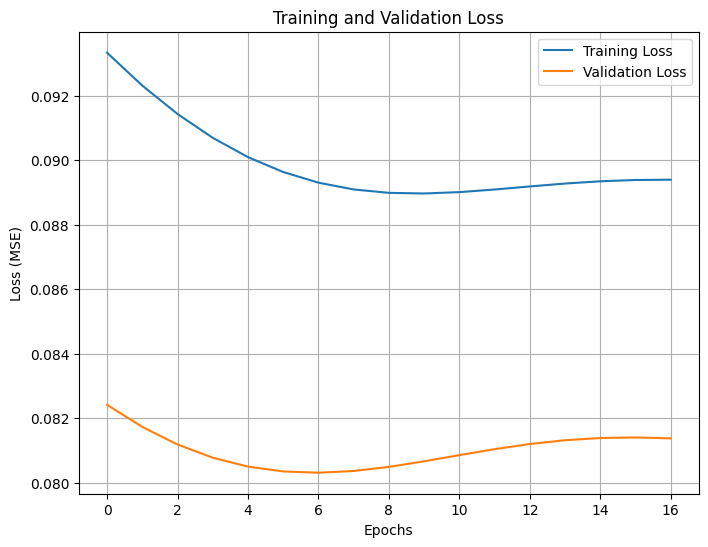

In [20]:
# Evaluate the model on the test set
print("Evaluating the model on the test set...")
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MAE: {test_mae}")

# Make predictionsarr_reduced = arr[0, :]
print("Making predictions on the test set...")
y_pred_normalized = np.abs(model.predict(X_test))

# Denormalize predictions and actual values
y_pred_denormalized = scaler_y.inverse_transform(y_pred_normalized).flatten()
y_test_denormalized = scaler_y.inverse_transform(y_test).flatten()

# Save the model
model.save('plastic_strain_predictor_model.h5')
print("Model saved as 'plastic_strain_predictor_model.h5'")

# Plot training and validation loss
plot_loss(history, filename='loss_curve.png')

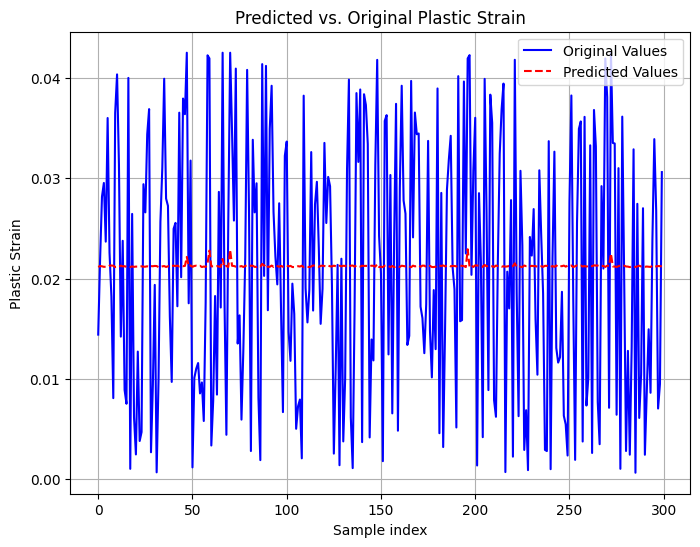

Plot saved as predicted_vs_actual


In [21]:
# Plot predicted vs original plastic strain
plot_predicted_vs_actual(y_test_denormalized, y_pred_denormalized, filename='predicted_vs_actual.png')